In [45]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
import os

In [46]:
# Load dataset for autoencoder training

df = pd.read_csv("../data/hand_landmarks_dataset_normalized_to_the_wrist.csv")
feature_columns = [col for col in df.columns if col.startswith(("x", "y"))]
X = df[feature_columns].values.astype(np.float32)

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")

Dataset loaded: 908 samples, 42 features


In [47]:
import tensorflow as tf


def create_autoencoder(input_dim):
    """
    Improved autoencoder with normalization, dropout, and better initialization.
    """
    model = tf.keras.models.Sequential(
        [
            # Input with noise for robustness
            tf.keras.layers.Input((input_dim,), name="input_layer"),
            tf.keras.layers.GaussianNoise(0.05, name="input_noise"),
            # Encoder
            tf.keras.layers.Dense(
                64, kernel_initializer="he_normal", name="encoder_dense1"
            ),
            tf.keras.layers.BatchNormalization(name="encoder_bn1"),
            tf.keras.layers.LeakyReLU(alpha=0.1, name="encoder_act1"),
            tf.keras.layers.Dense(
                32, kernel_initializer="he_normal", name="encoder_dense2"
            ),
            tf.keras.layers.BatchNormalization(name="encoder_bn2"),
            tf.keras.layers.LeakyReLU(alpha=0.1, name="encoder_act2"),
            # Bottleneck
            tf.keras.layers.Dense(
                8,
                activation=None,
                kernel_initializer="he_normal",
                activity_regularizer=tf.keras.regularizers.L1(1e-5),
                name="bottleneck",
            ),
            # Decoder
            tf.keras.layers.Dense(
                32, kernel_initializer="he_normal", name="decoder_dense1"
            ),
            tf.keras.layers.BatchNormalization(name="decoder_bn1"),
            tf.keras.layers.LeakyReLU(alpha=0.1, name="decoder_act1"),
            tf.keras.layers.Dense(
                64, kernel_initializer="he_normal", name="decoder_dense2"
            ),
            tf.keras.layers.BatchNormalization(name="decoder_bn2"),
            tf.keras.layers.LeakyReLU(alpha=0.1, name="decoder_act2"),
            # Output
            tf.keras.layers.Dense(input_dim, activation="linear", name="output_layer"),
        ]
    )

    # Use AdamW + Huber loss for stability
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5),
        loss=tf.keras.losses.Huber(),
    )

    return model


def train_autoencoder_model(X, epochs=20):
    """
    Train the autoencoder
    """
    X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

    autoencoder = create_autoencoder(X.shape[1])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=15, restore_best_weights=True
        )
    ]

    history = autoencoder.fit(
        X_train,
        X_train,
        validation_data=(X_val, X_val),
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1,
    )

    return autoencoder, X_train, history


def calculate_threshold(autoencoder, X_train, percentile=95):
    """
    Calculate reconstruction error threshold
    """
    reconstructions = autoencoder.predict(X_train, verbose=0)
    errors = np.mean(np.square(X_train - reconstructions), axis=1)
    threshold = np.percentile(errors, percentile)

    print(f"Threshold calculated: {threshold:.6f}")
    return threshold, errors


def save_autoencoder_model(autoencoder, threshold):
    """
    Save autoencoder and threshold
    """
    os.makedirs("../models", exist_ok=True)

    autoencoder.save("../models/autoencoder.keras")

    with open("../models/threshold.json", "w") as f:
        json.dump({"threshold": float(threshold)}, f)

    print("Autoencoder and threshold saved!")


def plot_training_results(history, errors, threshold):
    """
    Plot training results
    """
    import os

    os.makedirs("../models/autoencoder_plots", exist_ok=True)

    # Training history plot
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(
        "../models/autoencoder_plots/training_history.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    # Reconstruction errors plot
    plt.figure(figsize=(8, 6))
    plt.hist(errors, bins=50, alpha=0.7)
    plt.axvline(
        threshold, color="red", linestyle="--", label=f"Threshold: {threshold:.6f}"
    )
    plt.title("Reconstruction Errors")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.savefig(
        "../models/autoencoder_plots/reconstruction_errors.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()


def convert_to_tflite(autoencoder):
    """
    Convert autoencoder to TFLite
    """
    os.makedirs("../models/tflite", exist_ok=True)

    converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
    tflite_model = converter.convert()

    with open("../models/tflite/autoencoder.tflite", "wb") as f:
        f.write(tflite_model)

    print("Autoencoder converted to TFLite!")

In [48]:
# Train autoencoder
autoencoder, X_train, history = train_autoencoder_model(X, epochs=20)

Epoch 1/20


/Users/hassankalantari/Documents/Self Projects/AirSketch/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2158 - val_loss: 0.0868
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0718 - val_loss: 0.0460
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0314 - val_loss: 0.0302
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0192 - val_loss: 0.0218
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.0170
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - val_loss: 0.0141
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0098
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114 - val_loss: 0.0090
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0081
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - val_loss: 0.0074
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 - val_loss: 0.0070


In [49]:
# Calculate threshold
threshold, errors = calculate_threshold(autoencoder, X_train)

Threshold calculated: 0.011422


In [50]:
# Save models
save_autoencoder_model(autoencoder, threshold)

Autoencoder and threshold saved!


In [51]:
convert_to_tflite(autoencoder)

INFO:tensorflow:Assets written to: /var/folders/vm/p9d_yt5d4bv7vryrrsq_1psc0000gn/T/tmplhhhyl75/assets


INFO:tensorflow:Assets written to: /var/folders/vm/p9d_yt5d4bv7vryrrsq_1psc0000gn/T/tmplhhhyl75/assets


Saved artifact at '/var/folders/vm/p9d_yt5d4bv7vryrrsq_1psc0000gn/T/tmplhhhyl75'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 42), dtype=tf.float32, name=None)
Captures:
  5811824656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5811821968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5811825040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5811822736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5811820816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5811824848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5811822160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5811823888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5811824272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5811821392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5811822928: TensorSpec(shape=

W0000 00:00:1758904417.620695 2507340 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1758904417.620707 2507340 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


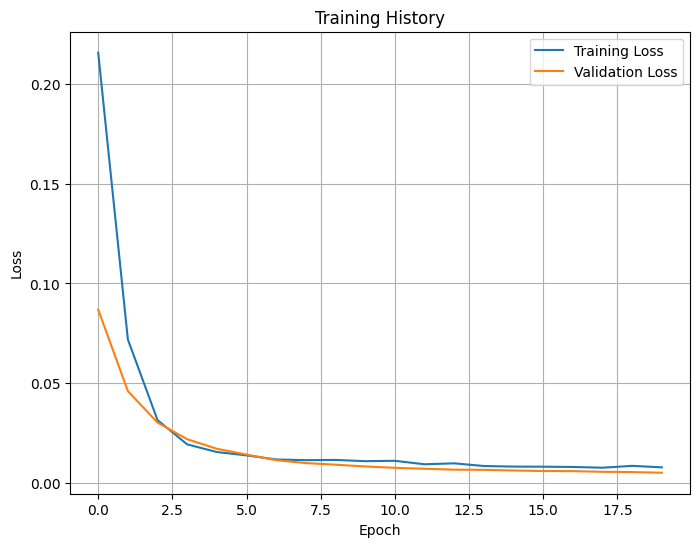

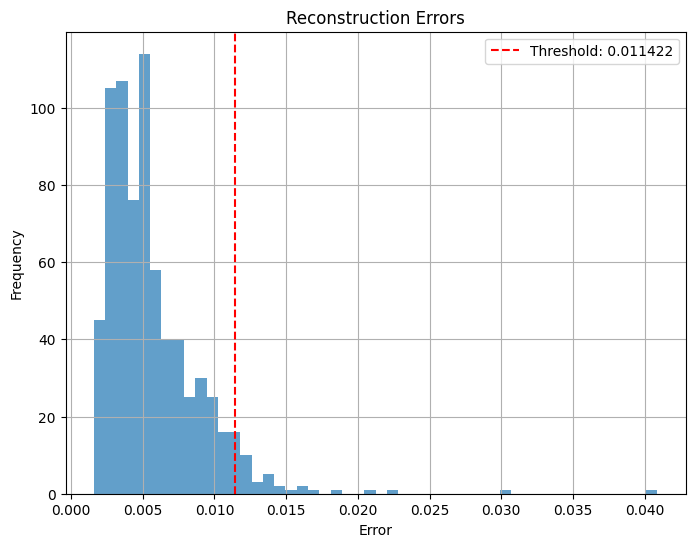

In [52]:
# Plot results
plot_training_results(history, errors, threshold)